In [1]:
# import the libraries


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Reshape , Multiply, Activation
from tensorflow.keras.layers import Input, DepthwiseConv2D, GlobalAveragePooling2D , Add, UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
import matplotlib.pyplot as plt
# from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions


In [2]:
 # Load CIFAR100 dataset
from tensorflow.keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# # Normalize pixel values
# x_train = X_train.astype('float32') / 255
# x_test = X_test.astype('float32') / 255
x_train = preprocess_input(X_train)
x_test = preprocess_input(X_test)


# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

169001437/169001437 [==============================] - 6s 0us/step


In [3]:
# Selected_Image = 13000
# image = x_train[Selected_Image]
# plt.imshow(image)
# plt.show()

In [4]:
# # Define the base model
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Define the model
# model = Sequential([
#     UpSampling2D(size=(7, 7), interpolation="bicubic", input_shape=(32, 32, 3)),  # Upsample from 32x32 to 224x224
#     ResNet50(weights='imagenet', include_top=False),  # Load pre-trained ResNet50 base
#     GlobalAveragePooling2D(),  # Add pooling layer to reduce dimensionality
#     # BatchNormalization(),
#     Dropout(0.3),  # Added Dropout
#     Dense(100, activation='softmax', kernel_regularizer=l2(0.001))  # Output layer for 100 classes with L2 regularization
# ])


# # # Make all layers non-trainable except for the last Dense layer
# # for layer in model.layers[:-1]:
# #     layer.trainable = False

# # # Make all layers non-trainable by default
# # for layer in model.layers:
# #     layer.trainable = False

# # # Fine-tuning the last few convolutional layers of ResNet50
# # for layer in model.layers[1].layers:  # Accessing ResNet50 directly
# #     if isinstance(layer, tf.keras.layers.Conv2D):
# #         layer.trainable = True

# # Set trainability of layers
# for layer in base_model.layers:
#     layer.trainable = False
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True


# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Model summary
# model.summary()

In [6]:
# # Train the model
# history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

In [7]:
# # Plot training results
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
# plt.show()

In [5]:
def create_model(dropout_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        UpSampling2D(size=(7, 7), interpolation="bicubic", input_shape=(32, 32, 3)),
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(100, activation='softmax')
    ])
    # Set the batch normalization layers to be trainable
    for layer in base_model.layers:
        layer.trainable = False
        if 'bn' in layer.name:
            layer.trainable = True
    return model

In [10]:
results_lr = []
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
for lr in learning_rates:
    model = create_model(dropout_rate=0.3)  # Use a fixed dropout for this loop
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training with learning rate: {lr}")
    history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))
    results_lr.append({
        'learning_rate': lr,
        'train_accuracy': max(history.history['accuracy']),
        'validation_accuracy': max(history.history['val_accuracy']),
        'train_loss': min(history.history['loss']),
        'validation_loss': min(history.history['val_loss'])
    })

94765736/94765736 [==============================] - 3s 0us/step
Training with learning rate: 0.1
Epoch 1/10
782/782 [==============================] - 166s 195ms/step - loss: 4.4138 - accuracy: 0.0895 - val_loss: 5.8020 - val_accuracy: 0.0801
Epoch 2/10
782/782 [==============================] - 158s 202ms/step - loss: 3.4385 - accuracy: 0.1515 - val_loss: 4.2290 - val_accuracy: 0.1325
Epoch 3/10
782/782 [==============================] - 158s 202ms/step - loss: 3.2600 - accuracy: 0.1818 - val_loss: 3.6466 - val_accuracy: 0.1948
Epoch 4/10
782/782 [==============================] - 158s 202ms/step - loss: 3.1409 - accuracy: 0.2041 - val_loss: 3.0904 - val_accuracy: 0.2251
Epoch 5/10
782/782 [==============================] - 158s 202ms/step - loss: 3.0627 - accuracy: 0.2184 - val_loss: 3.2112 - val_accuracy: 0.2232
Epoch 6/10
782/782 [==============================] - 149s 191ms/step - loss: 3.0019 - accuracy: 0.2275 - val_loss: 3.1206 - val_accuracy: 0.2367
Epoch 7/10
782/782 [======

In [13]:
results_bs = []
batch_sizes = [32, 64, 128]
for batch_size in batch_sizes:
    model = create_model(dropout_rate=0.3)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training with batch size: {batch_size}")
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=(x_test, y_test))
    results_bs.append({
        'batch_size': batch_size,
        'train_accuracy': max(history.history['accuracy']),
        'validation_accuracy': max(history.history['val_accuracy']),
        'train_loss': min(history.history['loss']),
        'validation_loss': min(history.history['val_loss'])
    })

Training with batch size: 32
Epoch 1/10
1563/1563 [==============================] - 172s 106ms/step - loss: 1.4543 - accuracy: 0.6041 - val_loss: 0.8184 - val_accuracy: 0.7584
Epoch 2/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.7880 - accuracy: 0.7640 - val_loss: 0.7346 - val_accuracy: 0.7828
Epoch 3/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.6383 - accuracy: 0.8012 - val_loss: 0.7173 - val_accuracy: 0.7912
Epoch 4/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.5523 - accuracy: 0.8251 - val_loss: 0.7026 - val_accuracy: 0.7933
Epoch 5/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.4820 - accuracy: 0.8455 - val_loss: 0.7012 - val_accuracy: 0.7988
Epoch 6/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.4368 - accuracy: 0.8572 - val_loss: 0.7084 - val_accuracy: 0.8022
Epoch 7/10
1563/1563 [==============================] - 171s 110ms/step - loss: 0.3

In [14]:
print(results_bs)

[{'batch_size': 32, 'train_accuracy': 0.8917999863624573, 'validation_accuracy': 0.8077999949455261, 'train_loss': 0.31640326976776123, 'validation_loss': 0.7012319564819336}, {'batch_size': 64, 'train_accuracy': 0.8971999883651733, 'validation_accuracy': 0.8061000108718872, 'train_loss': 0.2990402281284332, 'validation_loss': 0.6879111528396606}, {'batch_size': 128, 'train_accuracy': 0.902899980545044, 'validation_accuracy': 0.8033000230789185, 'train_loss': 0.2920788526535034, 'validation_loss': 0.6819848418235779}]


In [15]:
results_ec = []
epoch_counts = [5, 10, 15]
for epochs in epoch_counts:
    model = create_model(dropout_rate=0.3)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training for {epochs} epochs")
    history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_test, y_test))
    results_ec.append({
        'epoch_count': epochs,
        'train_accuracy': max(history.history['accuracy']),
        'validation_accuracy': max(history.history['val_accuracy']),
        'train_loss': min(history.history['loss']),
        'validation_loss': min(history.history['val_loss'])
    })

Training for 5 epochs
Epoch 1/5
782/782 [==============================] - 165s 205ms/step - loss: 1.5230 - accuracy: 0.5867 - val_loss: 0.8493 - val_accuracy: 0.7497
Epoch 2/5
782/782 [==============================] - 149s 191ms/step - loss: 0.7709 - accuracy: 0.7665 - val_loss: 0.7495 - val_accuracy: 0.7708
Epoch 3/5
782/782 [==============================] - 158s 202ms/step - loss: 0.6177 - accuracy: 0.8074 - val_loss: 0.6943 - val_accuracy: 0.7922
Epoch 4/5
782/782 [==============================] - 158s 202ms/step - loss: 0.5243 - accuracy: 0.8340 - val_loss: 0.6940 - val_accuracy: 0.7939
Epoch 5/5
782/782 [==============================] - 158s 202ms/step - loss: 0.4648 - accuracy: 0.8502 - val_loss: 0.6829 - val_accuracy: 0.7979
Training for 10 epochs
Epoch 1/10
782/782 [==============================] - 156s 194ms/step - loss: 1.5379 - accuracy: 0.5831 - val_loss: 0.8375 - val_accuracy: 0.7507
Epoch 2/10
782/782 [==============================] - 158s 202ms/step - loss: 0.7781

In [16]:
print(results_ec)

[{'epoch_count': 5, 'train_accuracy': 0.8502200245857239, 'validation_accuracy': 0.7979000210762024, 'train_loss': 0.4647664427757263, 'validation_loss': 0.6829187870025635}, {'epoch_count': 10, 'train_accuracy': 0.8975200057029724, 'validation_accuracy': 0.8030999898910522, 'train_loss': 0.2999616265296936, 'validation_loss': 0.6853528022766113}, {'epoch_count': 15, 'train_accuracy': 0.9197400212287903, 'validation_accuracy': 0.8076000213623047, 'train_loss': 0.2283027172088623, 'validation_loss': 0.6820119619369507}]


In [6]:
results_dr = []
dropout_rates = [0.1, 0.3, 0.5]
for dropout_rate in dropout_rates:
    model = create_model(dropout_rate)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training with dropout rate: {dropout_rate}")
    history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))
    results_dr.append({
        'dropout_rate': dropout_rate,
        'train_accuracy': max(history.history['accuracy']),
        'validation_accuracy': max(history.history['val_accuracy']),
        'train_loss': min(history.history['loss']),
        'validation_loss': min(history.history['val_loss'])
    })

94765736/94765736 [==============================] - 3s 0us/step
Training with dropout rate: 0.1
Epoch 1/10
782/782 [==============================] - 165s 196ms/step - loss: 1.3890 - accuracy: 0.6187 - val_loss: 0.8587 - val_accuracy: 0.7475
Epoch 2/10
782/782 [==============================] - 159s 204ms/step - loss: 0.6810 - accuracy: 0.7911 - val_loss: 0.7419 - val_accuracy: 0.7785
Epoch 3/10
782/782 [==============================] - 159s 204ms/step - loss: 0.5210 - accuracy: 0.8355 - val_loss: 0.7210 - val_accuracy: 0.7896
Epoch 4/10
782/782 [==============================] - 151s 193ms/step - loss: 0.4201 - accuracy: 0.8647 - val_loss: 0.7116 - val_accuracy: 0.7963
Epoch 5/10
782/782 [==============================] - 151s 193ms/step - loss: 0.3489 - accuracy: 0.8861 - val_loss: 0.7080 - val_accuracy: 0.7979
Epoch 6/10
782/782 [==============================] - 159s 204ms/step - loss: 0.3010 - accuracy: 0.9009 - val_loss: 0.7609 - val_accuracy: 0.7886
Epoch 7/10
782/782 [=======

In [7]:
print(results_dr)

[{'dropout_rate': 0.1, 'train_accuracy': 0.9381200075149536, 'validation_accuracy': 0.7997000217437744, 'train_loss': 0.18315285444259644, 'validation_loss': 0.7079647779464722}, {'dropout_rate': 0.3, 'train_accuracy': 0.9002400040626526, 'validation_accuracy': 0.805400013923645, 'train_loss': 0.292791485786438, 'validation_loss': 0.6914432048797607}, {'dropout_rate': 0.5, 'train_accuracy': 0.8553199768066406, 'validation_accuracy': 0.807200014591217, 'train_loss': 0.4400807321071625, 'validation_loss': 0.6618813872337341}]


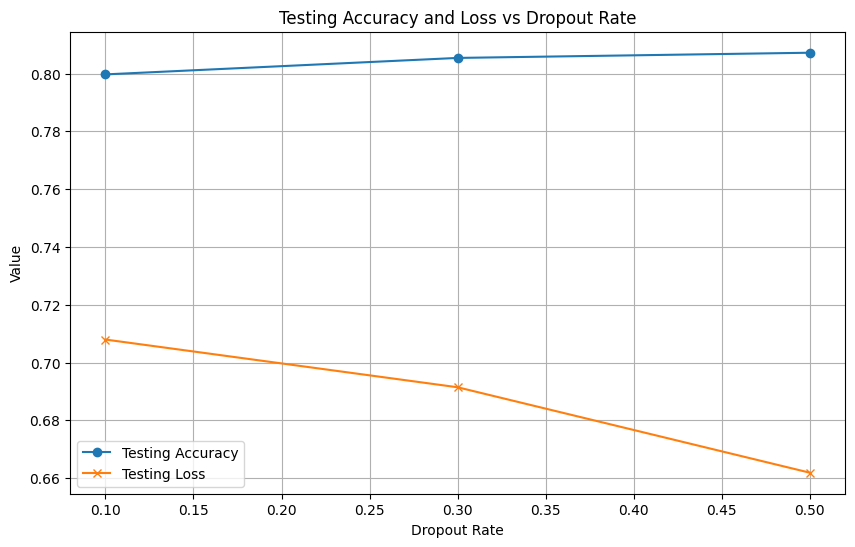

In [1]:
import matplotlib.pyplot as plt

# Data provided
results = [
    {'dropout_rate': 0.1, 'train_accuracy': 0.9381200075149536, 'validation_accuracy': 0.7997000217437744,
     'train_loss': 0.18315285444259644, 'validation_loss': 0.7079647779464722},
    {'dropout_rate': 0.3, 'train_accuracy': 0.9002400040626526, 'validation_accuracy': 0.805400013923645,
     'train_loss': 0.292791485786438, 'validation_loss': 0.6914432048797607},
    {'dropout_rate': 0.5, 'train_accuracy': 0.8553199768066406, 'validation_accuracy': 0.807200014591217,
     'train_loss': 0.4400807321071625, 'validation_loss': 0.6618813872337341}
]

# Extracting data for plotting
dropout_rates = [d['dropout_rate'] for d in results]
test_accuracies = [d['validation_accuracy'] for d in results]
test_losses = [d['validation_loss'] for d in results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dropout_rates, test_accuracies, label='Testing Accuracy', marker='o')
plt.plot(dropout_rates, test_losses, label='Testing Loss', marker='x')
plt.title('Testing Accuracy and Loss vs Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


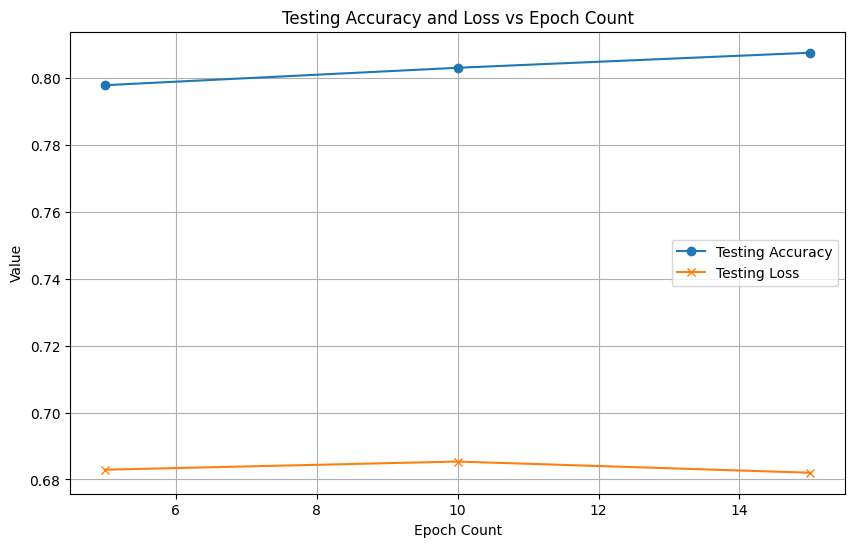

In [3]:
import matplotlib.pyplot as plt

# Data for epoch counts
epoch_data = [
    {'epoch_count': 5, 'train_accuracy': 0.8502200245857239, 'validation_accuracy': 0.7979000210762024,
     'train_loss': 0.4647664427757263, 'validation_loss': 0.6829187870025635},
    {'epoch_count': 10, 'train_accuracy': 0.8975200057029724, 'validation_accuracy': 0.8030999898910522,
     'train_loss': 0.2999616265296936, 'validation_loss': 0.6853528022766113},
    {'epoch_count': 15, 'train_accuracy': 0.9197400212287903, 'validation_accuracy': 0.8076000213623047,
     'train_loss': 0.2283027172088623, 'validation_loss': 0.6820119619369507}
]

# Extracting data for plotting
epoch_counts = [d['epoch_count'] for d in epoch_data]
test_accuracies_epoch = [d['validation_accuracy'] for d in epoch_data]
test_losses_epoch = [d['validation_loss'] for d in epoch_data]

# Plotting the epoch results
plt.figure(figsize=(10, 6))
plt.plot(epoch_counts, test_accuracies_epoch, label='Testing Accuracy', marker='o')
plt.plot(epoch_counts, test_losses_epoch, label='Testing Loss', marker='x')
plt.title('Testing Accuracy and Loss vs Epoch Count')
plt.xlabel('Epoch Count')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

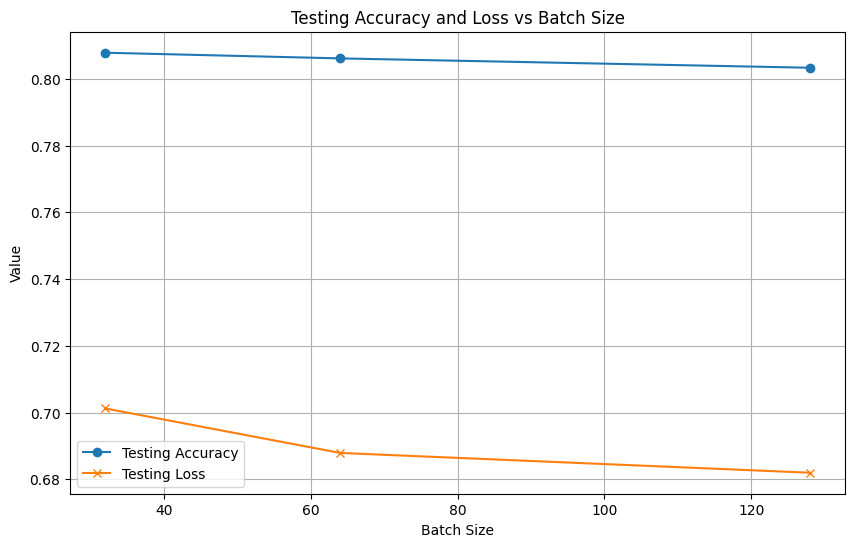

In [6]:
import matplotlib.pyplot as plt

# Data for batch sizes
batch_data = [
    {'batch_size': 32, 'train_accuracy': 0.8917999863624573, 'validation_accuracy': 0.8077999949455261,
     'train_loss': 0.31640326976776123, 'validation_loss': 0.7012319564819336},
    {'batch_size': 64, 'train_accuracy': 0.8971999883651733, 'validation_accuracy': 0.8061000108718872,
     'train_loss': 0.2990402281284332, 'validation_loss': 0.6879111528396606},
    {'batch_size': 128, 'train_accuracy': 0.902899980545044, 'validation_accuracy': 0.8033000230789185,
     'train_loss': 0.2920788526535034, 'validation_loss': 0.6819848418235779}
]

# Extracting data for plotting
batch_sizes = [d['batch_size'] for d in batch_data]
test_accuracies_batch = [d['validation_accuracy'] for d in batch_data]
test_losses_batch = [d['validation_loss'] for d in batch_data]

# Plotting the batch size results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, test_accuracies_batch, label='Testing Accuracy', marker='o')
plt.plot(batch_sizes, test_losses_batch, label='Testing Loss', marker='x')
plt.title('Testing Accuracy and Loss vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


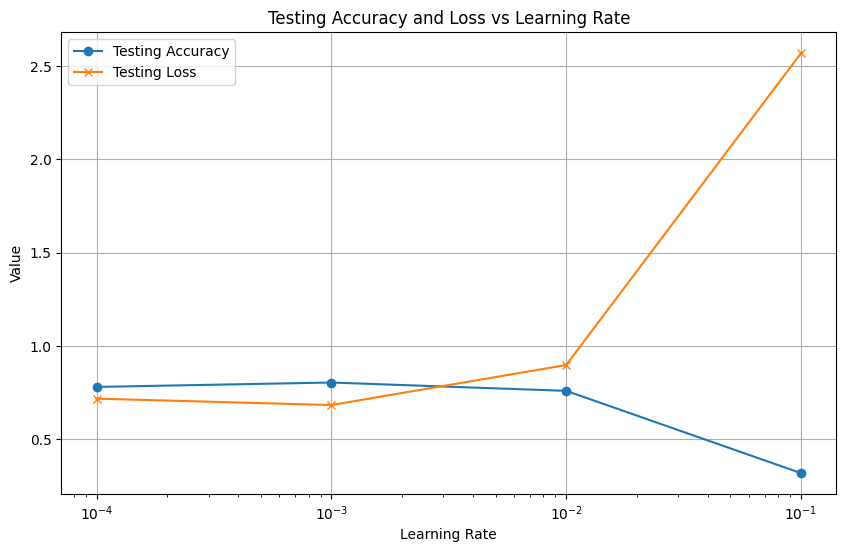

In [7]:
import matplotlib.pyplot as plt

# Data from the input
data = [
    {"learning": 0.1, "validation_accuracy": 0.3184, "validation_loss": 2.5682},
    {"learning": 0.01, "validation_accuracy": 0.7591, "validation_loss": 0.8975},
    {"learning": 0.001, "validation_accuracy": 0.8037, "validation_loss": 0.6830},
    {"learning": 0.0001, "validation_accuracy": 0.7801, "validation_loss": 0.7175}
]

# Extracting data for plotting
learning_rates = [d["learning"] for d in data]
test_accuracies = [d["validation_accuracy"] for d in data]
test_losses = [d["validation_loss"] for d in data]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, test_accuracies, label='Testing Accuracy', marker='o')
plt.plot(learning_rates, test_losses, label='Testing Loss', marker='x')
plt.title('Testing Accuracy and Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Value')
plt.xscale('log')  # Setting x-axis to logarithmic scale for better visualization
plt.legend()
plt.grid(True)
plt.show()
